# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [1]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python
# !pip install pillow

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [3]:
class_labels = [
    'Aipan Art (Uttarakhand)',
    'Assamese Miniature Painting (Assam)',
    'Basholi Painting (Jammu and Kashmir)',
    'Bhil Painting (Madhya Pradesh)',
    'Chamba Rumal (Himachal Pradesh)',
    'Cheriyal Scroll Painting (Telangana)',
    'Dokra Art(West Bengal)',
    'Gond Painting (Madhya Pradesh)',
    'Kalamkari Painting (Andra Pradesh and Telangana)',
    'Kalighat Painting (West Bengal)',
    'Kangra Painting (Himachal Pradesh)',
    'Kerala Mural Painting (Kerala)',
    'Kondapalli Bommallu (Andra Pradesh)',
    'Kutch Lippan Art (Gujarat)',
    'Leather Puppet Art (Andra Pradesh)',
    'Madhubani Painting (Bihar)',
    'Mandala Art',
    'Mandana Art (Rajasthan)',
    'Mata Ni Pachedi (Gujarat)',
    'Meenakari Painting (Rajasthan)',
    'Mughal Paintings',
    'Mysore Ganjifa Art (Karnataka)',
    'Pattachitra Painting (Odisha and Bengal)',
    'Patua Painting (West Bengal)',
    'Pichwai Painting (Rajasthan)',
    'Rajasthani Miniature Painting (Rajasthan)',
    'Rogan Art from Kutch (Gujarat)',
    'Sohrai Art (Jharkhand)',
    'Tikuli Art (Bihar)',
    'Warli Folk Painting (Maharashtra)'
]


In [4]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Validate ratios
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Train, validation, and test ratios must sum to 1.")
    
    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)
    
    # Iterate over each class folder
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Get all files in the class folder
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Split files into train, validation, and test sets
        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Copy files to destination directories
        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_class_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
    
    print("Data successfully split into train, validation, and test sets.")

# Example usage:
source_directory = "C:\\Users\PC\\Downloads\\folk-art-dataset-main"
destination_directory = "./dataset"

# split_data(source_directory, destination_directory)


In [5]:
def convert_images_to_jpg(dataset_dir):
    # Supported extensions for conversion
    supported_extensions = ['.jpeg', '.png', '.gif']
    
    # Traverse through the dataset directory
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            file_name, file_ext = os.path.splitext(file)

            # Check if file has a supported extension
            if file_ext.lower() in supported_extensions:
                try:
                    # Open the image
                    img = Image.open(file_path).convert('RGBA')
                    
                    # New file path with the same directory but `.jpg` extension
                    new_file_path = os.path.join(root, f"{file_name}.jpg")
                    
                    # Save the image as `.jpg`
                    img.save(new_file_path, 'JPEG')
                    
                    # Delete the original file
                    os.remove(file_path)
                    
                    print(f"Converted and replaced: {file_path} -> {new_file_path}")
                except Exception as e:
                    print(f"Error converting {file_path}: {e}")

# Example usage
dataset_directory = "./dataset"
# convert_images_to_jpg(dataset_directory)


In [6]:
img_size = (128, 128)
batch_size = 16

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/mithila-art-classification-dataset/dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 21151 images belonging to 30 classes.


In [8]:
print("Class Indices:", train_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/mithila-art-classification-dataset/dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4522 images belonging to 30 classes.


In [10]:
print("Class Indices:", test_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/mithila-art-classification-dataset/dataset/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4543 images belonging to 30 classes.


In [12]:
print("Class Indices:", val_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

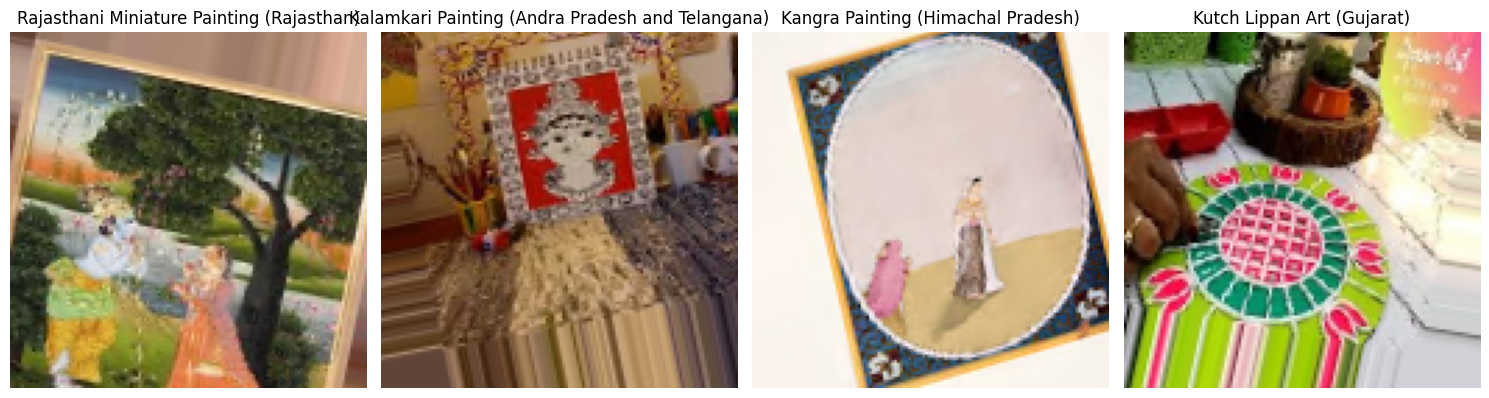

In [13]:

images, labels = next(train_generator)  # Fetches the next batch

num_images = 4
plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization

for index in range(num_images):
    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image
    plt.imshow(images[index])  # Display the image
    class_label = labels[index].argmax()  # Get the class index from one-hot encoding
    class_name = list(train_generator.class_indices.keys())[class_label]  # Get class name
    plt.title(class_name)  # Set the title to the class name
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()



In [14]:
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(30, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,767,262 (60.15 MB)

 Trainable params: 1,052,574 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Define the log directory
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=4,                # Number of epochs to wait before stopping
    restore_best_weights=True  # Restores the weights of the best epoch
)

In [18]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733262986.438590      88 service.cc:145] XLA service 0x7d815c001e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733262986.438643      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733262990.696436      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1319/1322 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1566 - loss: 3.0703

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1322/1322 ━━━━━━━━━━━━━━━━━━━━ 200s 146ms/step - accuracy: 0.1568 - loss: 3.0695 - val_accuracy: 0.3658 - val_loss: 2.3291
Epoch 2/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.3367 - loss: 2.3910 - val_accuracy: 0.4319 - val_loss: 2.0817
Epoch 3/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.3816 - loss: 2.1919 - val_accuracy: 0.4497 - val_loss: 1.9894
Epoch 4/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 125s 94ms/step - accuracy: 0.4196 - loss: 2.0649 - val_accuracy: 0.4810 - val_loss: 1.9000
Epoch 5/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 123s 92ms/step - accuracy: 0.4409 - loss: 1.9666 - val_accuracy: 0.4935 - val_loss: 1.8359
Epoch 6/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 125s 94ms/step - accuracy: 0.4619 - loss: 1.8986 - val_accuracy: 0.4959 - val_loss: 1.8208
Epoch 7/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 124s 94ms/step - accuracy: 0.4776 - loss: 1.8449 - val_accuracy: 0.4889 - val_loss: 1.8178
Epoch 8/40
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 123s 93ms/step - accuracy: 0.4894 - l

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.5845 - loss: 1.5062
Test Accuracy: 0.5860238671302795


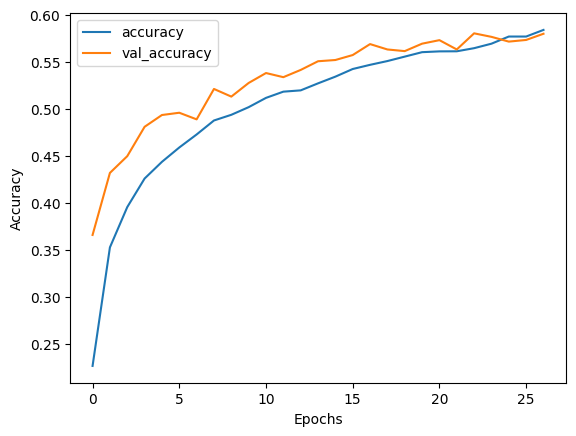

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

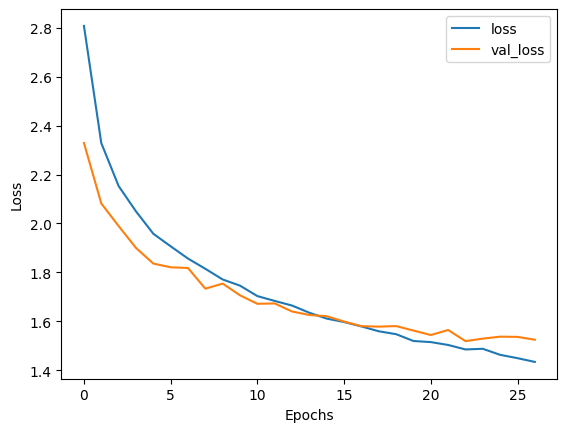

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.models import load_model


In [23]:
model.save('art-classification-v4.h5')

In [24]:
# model = load_model('./model/art-classification-v2.h5')

In [25]:
test_images, test_labels = next(test_generator)

In [26]:
img_predict = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


In [27]:
np.argmax(test_labels[0])

1

In [28]:
np.argmax(img_predict[0])

1

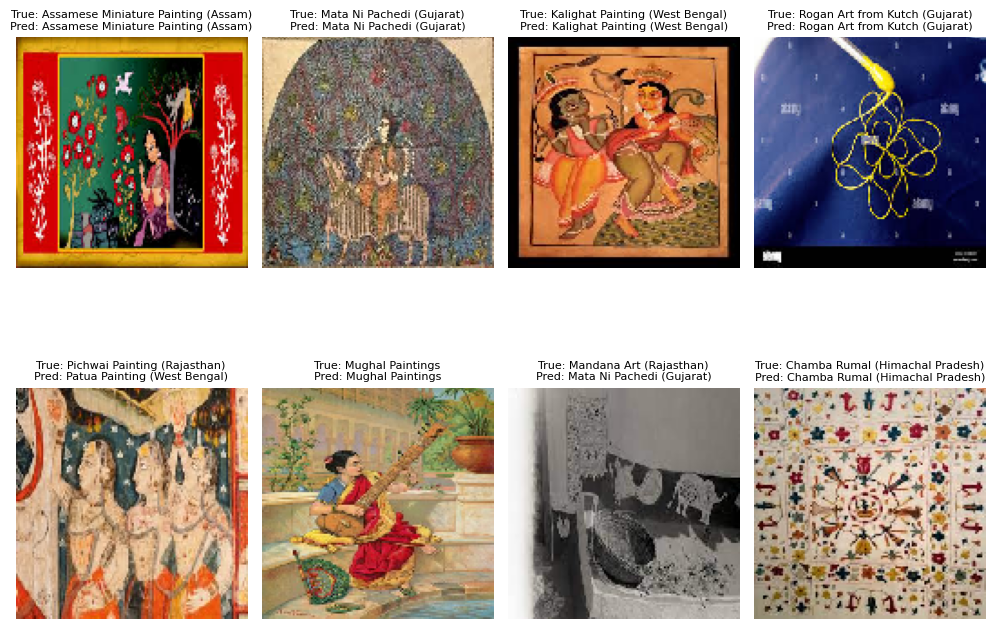

In [29]:
# Plotting
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)  # Create a grid of subplots (2 rows, 4 columns)
    plt.imshow(test_images[i], cmap="gray")  # Display the image in grayscale
    
    # Get predicted and true class names
    predicted_class = class_labels[np.argmax(img_predict[i])]
    true_class = class_labels[np.argmax(test_labels[i])]
    
    # Display predicted and true class names
    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)
    plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()
